In [2]:
!pip install numpy
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def DFT_unitary(x: np.ndarray) -> np.ndarray:
    """Discrete Fourier Tranform unitary(unitary matrix preserves norms)
    x: input signal
    return: DFT of x"""
    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    exp_ = np.exp(-1j * 2 * np.pi * k * n / N)
    X = (1 / np.sqrt(N)) * np.dot(exp_, x)
    return X


def fourier_ratio(x: np.ndarray) -> float:
    """Fourier ratio
    x: input signal
    return: Fourier ratio FR = L1 / L2"""
    X = DFT_unitary(x)
    L1 = np.sum(np.abs(X))
    L2 = np.sqrt(np.sum(np.abs(X) ** 2))
    FR = L1 / L2
    return FR.real


def compute_required_fourier_terms(eta: float, x: np.ndarray) -> int:
    """
    Compute the required number of Fourier terms
    needed for the  approximation with accuracy eta,
    according to Theorem 1.14.
    """
    FR = fourier_ratio(x)
    k = (FR**2 - 1) / (eta**2)
    return int(np.floor(k + 1))


def build_Z(f: np.ndarray) -> np.ndarray | None:
    """Building Z random Fourier component from Proof 1.14
    f: input signal
    return: Z random Fourier component"""
    N = len(f)
    f_hat = DFT_unitary(f)

    abs_hat = np.abs(f_hat)
    L1 = abs_hat.sum()

    if L1 == 0:
        return np.zeros_like(f, dtype=complex)

    probs = abs_hat / L1

    m = np.random.choice(len(f_hat), p=probs)

    if abs_hat[m] == 0:
        sgn = 0.0
    else:
        sgn = f_hat[m] / abs_hat[m]

    x_idx = np.arange(N)
    chi_mx = np.exp(2j * np.pi * m * x_idx / N)

    Z = L1 * sgn * (1 / np.sqrt(N)) * chi_mx

    return Z


def approximate_f_by_Z(f: np.ndarray, k: int) -> np.ndarray:
    """Approximate f by k random Fourier components Z Just by averaging
    f: input signal
    k: number of random Fourier components
    return: approximation of f by k random Fourier components Z
    """
    N = len(f)
    acc = np.zeros(N, dtype=complex)
    for _ in range(k):
        Z = build_Z(f)
        acc += Z
    return acc / k


def deterministic_trig_approx(
    f: np.ndarray,
    eps: float = 1.0,
) -> tuple[np.ndarray, float, int, np.ndarray, np.ndarray]:
    """
    Deterministic trigonometric polynomial construction
    based on derandomization of Theorem 1.15.

    Parameters
    ----------
    f : array-like, complex or real
        Input discrete signal, length N
    eps : float
        Desired relative accuracy (η in the theorem)
    C : float
        Constant multiplier for k (default=100 as in the lecture)

    Returns
    -------
    P : ndarray (complex)
        Approximating trigonometric polynomial evaluated on all x
    rel_error : float
        Relative L2 error ||f - P||_2 / ||f||_2
    k : int
        Number of deterministic samples (polynomial complexity)
    a : ndarray
        Coefficients a[m] of the trig polynomial
    c : ndarray
        Multiplicity counts c[m] used in derandomization
    """
    f = np.asarray(f, dtype=np.complex128)
    N = len(f)
    f_hat = DFT_unitary(f)
    abs_fhat = np.abs(f_hat)
    L1 = abs_fhat.sum()
    k = compute_required_fourier_terms(eps, f)
    p = abs_fhat / L1
    t = k * p
    c = np.floor(t).astype(int)
    S = c.sum()
    if S < k:
        R = k - S
        frac = t - np.floor(t)
        idx = np.argsort(-frac)
        c[idx[:R]] += 1
    sign = np.where(f_hat == 0, 0, f_hat / abs_fhat)
    a = (L1 / (k * np.sqrt(N))) * sign * c
    x = np.arange(N)
    m = np.arange(N)
    W = np.exp(2j * np.pi * np.outer(x, m) / N)
    P = W @ a
    rel_error = np.linalg.norm(f - P) / np.linalg.norm(f)

    return P, rel_error, k, a, c


def periodic_forecast(a: np.ndarray, N: int, H: int) -> np.ndarray:
    """
    Periodic forecast using trig polynomial P(x) reconstructed from coefficients a[m].

    a : array of trig polynomial coefficients
    N : original signal length
    H : forecast horizon (number of future points)

    Returns:
        P_future : predicted values for x = N, N+1, ..., N+H-1
    """
    m = np.arange(N)
    x_future = np.arange(N, N + H)

    W_future = np.exp(2j * np.pi * np.outer(x_future, m) / N)

    P_future = W_future @ a
    return P_future

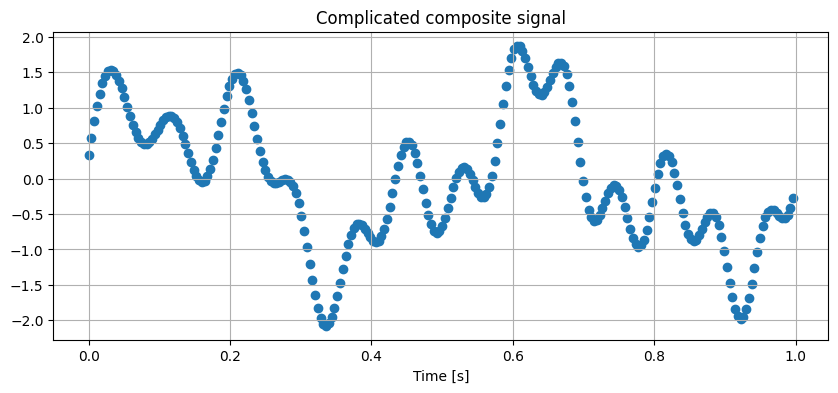

FR(Complicated composite signal) = 3.607819619520028
Bound for fourier_ratio: (1, 16.0)
Polynomial degree: 13


In [20]:
sr = 256  # sampling rate (Hz)
eta = 1
seconds = 1
N = sr * seconds # for every second 500 samples total samples sr * seconds
# time vector
t = np.linspace(0, seconds, N, endpoint=False) 
#try here different signals
x = (
    np.sin(2 * np.pi * 2 * t)
    + 0.7 * np.sin(2 * np.pi * 5 * t + 0.5)
    + 0.5 * np.sin(2 * np.pi * (10 + 3 * np.sin(2 * np.pi * 0.2 * t)) * t)
)

plt.figure(figsize=(10, 4))
plt.scatter(t, x)
plt.title("Complicated composite signal")
plt.xlabel("Time [s]")
plt.grid(True)
plt.show()

X = DFT_unitary(x)
k = compute_required_fourier_terms(eta, x)

print("FR(Complicated composite signal) =", fourier_ratio(x))
print(f"Bound for fourier_ratio: (1, {np.sqrt(N)})")
print(f"Polynomial degree: {k}")

Relative error: 0.0040228086562814225


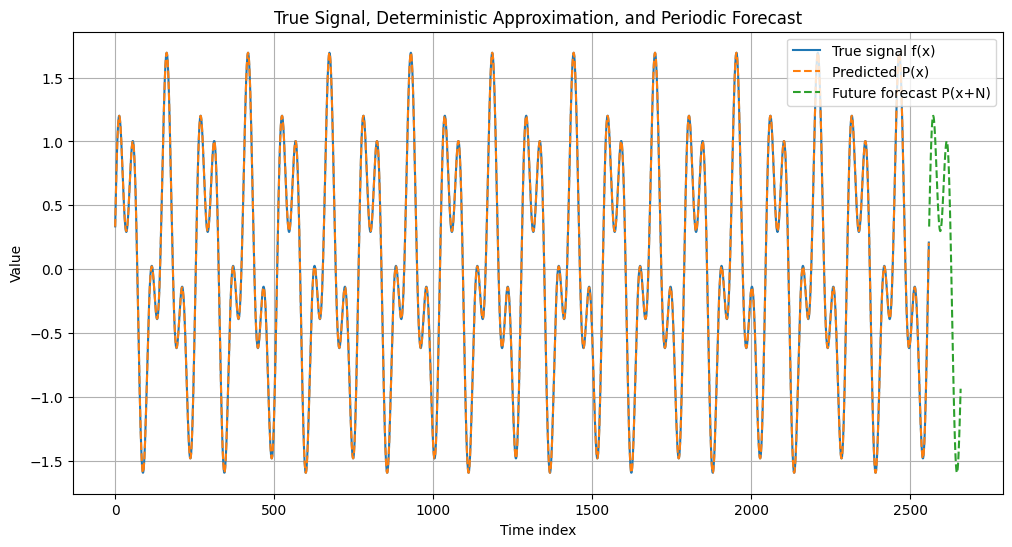

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------------
# DEMO: build signal, fit, forecast, plot
# ----------------------------------------

# 1) Generate sample signal


# 2) Deterministic trig approximation
P, rel_error, k, a, c = deterministic_trig_approx(x, eps=0.1)
print("Relative error:", rel_error)

# 3) Forecast H future points
H = 100
P_future = periodic_forecast(a, N, H)

# 4) Build full timeline for plotting
t_full = np.arange(N + H)

# 5) Plot true, predicted, and future
plt.figure(figsize=(12, 6))

plt.plot(t_full[:N], x.real, label="True signal f(x)")
plt.plot(t_full[:N], P.real, label="Predicted P(x)", linestyle="--")
plt.plot(t_full[N:], P_future.real, label="Future forecast P(x+N)", linestyle="--")

plt.title("True Signal, Deterministic Approximation, and Periodic Forecast")
plt.xlabel("Time index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

plt.show()


In [7]:
import matplotlib.pyplot as plt
import numpy as np
f_approx = approximate_f_by_Z(x, k=k)

f_pred_random = np.real(f_approx)
f_pred_deterministic, rel_error, k_det, a_det, c_det = deterministic_trig_approx(x, eps=eta)

plt.figure(figsize=(10, 4))
plt.plot(t, x, label="true f(x)")
plt.plot(t, f_pred_random, label="approx f(x) from Z", linestyle="--")
plt.plot(t, f_pred_deterministic, label="approx f(x) deterministic", linestyle="-.")
plt.xlabel("time")
plt.ylabel("amplitude")
plt.title("True vs approximated signal")
plt.grid(True)
plt.legend()
plt.show()
num = np.linalg.norm(x - f_pred_random)   # ||f - P||_2
den = np.linalg.norm(x)            # ||f||_2
accuracy_ratio = num / den         # має бути < eta

print("||f - P|| / ||f|| =", accuracy_ratio)
print("OK?", accuracy_ratio < eta)

KeyboardInterrupt: 

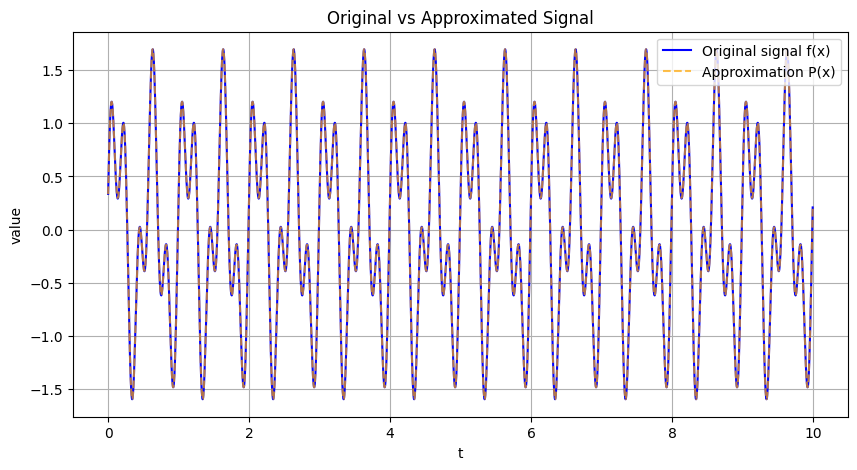

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(t, x.real, color='blue', label='Original signal f(x)')
plt.plot(t, P.real, color='orange', label='Approximation P(x)', alpha=0.7, linestyle='--')

plt.title("Original vs Approximated Signal")
plt.xlabel("t")
plt.ylabel("value")
plt.legend()

plt.grid(True)
plt.show()


## Missing values

Fourier Ratio FR: 1.9696
Sampling rate SR: 25
FR: 1.9696
q (theoretical): 79
Number of used observations: 79
Relative error (full signal):    1.9237e-01
Relative error (missing points): 3.0933e-01

=== Theorem 1.20 bound check ===
||x* - f||_2        = 1.8564e+00
11.47 ||f||_2 eps   = 1.1069e+01
lhs / rhs           = 0.168
✅ Bound holds.


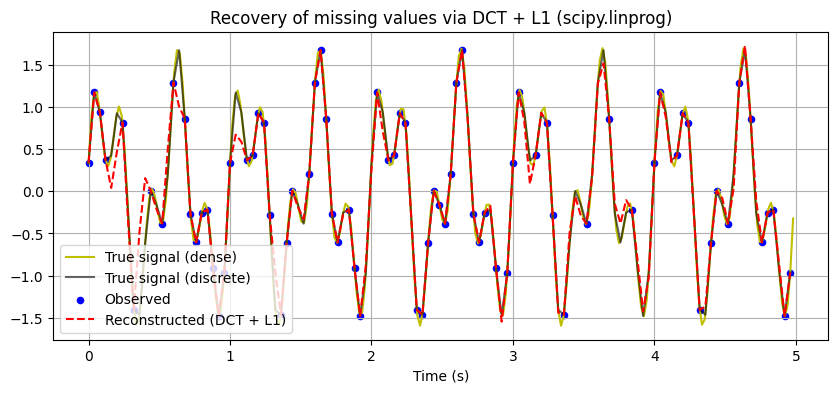

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from scipy.optimize import linprog


def original_signal(x: np.ndarray) -> np.ndarray:
    """Original signal"""
    return np.sin(2 * np.pi * 2 * x) + 0.7 * np.sin(2 * np.pi * 5 * x + 0.5)


def sample_signal(sr: int, seconds: float) -> tuple[np.ndarray, np.ndarray]:
    """Return time grid t and discretized signal f_full."""
    N = sr * seconds
    t = np.linspace(0, seconds, N, endpoint=False)
    f_full = original_signal(t)
    return t, f_full


def mask_observations(f_full: np.ndarray, keep_prob: float, seed: int = 0):
    """
    Randomly keep each sample with probability keep_prob
    and set the others to NaN (simulate missing values).
    Returns: (mask, f_obs).
    """
    rng = np.random.default_rng(seed)
    mask = rng.random(len(f_full)) < keep_prob  # True = observed, False = missing
    f_obs = f_full.copy()
    f_obs[~mask] = np.nan
    return mask, f_obs


def compute_q(FR: float, eps: float, N: int, C: float, max_available: int) -> int:
    """
    Compute q using the formula from Theorem 1.20 and
    clip it to the number of actually available observations.
    """
    q_theor = int(C * FR**2 / eps**2 * np.log(FR / eps) ** 2 * np.log(N))
    return min(q_theor, max_available)


def build_dct_basis(N: int) -> np.ndarray:
    """Return orthonormal DCT basis matrix of size N x N."""
    I = np.eye(N)
    B = fftpack.dct(I, type=2, norm="ortho", axis=0)
    return B


def recover_l1_via_lp(A: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Solve the L1-minimization problem

        min ||c||_1  subject to A c = y

    by converting it to a linear program using c = c_plus - c_minus.
    Returns: recovered coefficient vector c.
    """
    q, N = A.shape
    n_vars = N

    # Objective: minimize sum(c_plus + c_minus)
    c_obj = np.ones(2 * n_vars)

    A_eq = np.hstack([A, -A])  # shape (q, 2N)
    b_eq = y

    # Bounds: c_plus >= 0, c_minus >= 0
    bounds = [(0, None)] * (2 * n_vars)

    res = linprog(c=c_obj, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")

    if res.status != 0:
        raise RuntimeError(f"LP did not converge: {res.message}")

    c_plus = res.x[:n_vars]
    c_minus = res.x[n_vars:]
    c_rec = c_plus - c_minus
    return c_rec


def check_theorem_bound(f_full: np.ndarray, f_rec: np.ndarray, eps: float):
    """
    Check the inequality from Theorem 1.20:

        ||x* - f||_2 <= 11.47 * ||f||_2 * eps

    Returns (lhs, rhs, lhs/rhs, ok_flag).
    """
    norm_f = np.linalg.norm(f_full)
    err = np.linalg.norm(f_rec - f_full)

    lhs = err
    rhs = 11.47 * norm_f * eps
    ok = lhs <= rhs

    return lhs, rhs, lhs / rhs, ok


def plot_reconstruction(t, f_full, mask, f_obs, f_rec, seconds: float):
    """Plot true, observed and reconstructed signals."""
    t_dense = np.linspace(0, seconds, 256, endpoint=False)
    f_dense = original_signal(t_dense)

    plt.figure(figsize=(10, 4))
    plt.plot(t_dense, f_dense, "y", label="True signal (dense)")
    plt.plot(t, f_full, "k", alpha=0.6, label="True signal (discrete)")
    plt.scatter(t[mask], f_obs[mask], c="b", s=20, label="Observed")
    plt.plot(t, f_rec, "r--", label="Reconstructed (DCT + L1)")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Time (s)")
    plt.title("Recovery of missing values via DCT + L1 (scipy.linprog)")
    plt.show()



def run_experiment(
    FR,
    sr: int = 32,
    seconds: float = 2.0,
    eps: float = 0.5,
    C: float = 1.0,
    keep_prob: float = 0.7,
    seed: int = 0,
):
    print("Sampling rate SR:", sr)

    t, f_full = sample_signal(sr, seconds)
    N = len(f_full)

    print(f"FR: {FR:.4f}")

    mask, f_obs = mask_observations(f_full, keep_prob=keep_prob, seed=seed)

    valid_idx = np.where(mask)[0]

    q = compute_q(FR=FR, eps=eps, N=N, C=C, max_available=len(valid_idx))
    print(f"q (theoretical): {q}")

    obs_idx = np.random.choice(valid_idx, q, replace=False)
    y = f_obs[obs_idx]
    print(f"Number of used observations: {len(y)}")

    B = build_dct_basis(N)
    A = B[obs_idx, :]

    c_rec = recover_l1_via_lp(A, y)
    f_rec = B @ c_rec

    f_filled = f_obs.copy()
    f_filled[~mask] = f_rec[~mask]

    rel_err_full = np.linalg.norm(f_rec - f_full) / np.linalg.norm(f_full)
    rel_err_missing = np.linalg.norm(f_rec[~mask] - f_full[~mask]) / np.linalg.norm(
        f_full[~mask]
    )
    print(f"Relative error (full signal):    {rel_err_full:.4e}")
    print(f"Relative error (missing points): {rel_err_missing:.4e}")

    lhs, rhs, ratio, ok = check_theorem_bound(f_full, f_rec, eps)
    print("\n=== Theorem 1.20 bound check ===")
    print(f"||x* - f||_2        = {lhs:.4e}")
    print(f"11.47 ||f||_2 eps   = {rhs:.4e}")
    print(f"lhs / rhs           = {ratio:.3f}")
    print("✅ Bound holds." if ok else " Bound does NOT hold for this eps, C, q.")

    # 12) Plot
    plot_reconstruction(t, f_full, mask, f_obs, f_rec, seconds)



if __name__ == "__main__":
    seconds = 5
    t_dense = np.linspace(0, seconds, 256, endpoint=False)
    f_dense = original_signal(t_dense)
    FR = fourier_ratio(f_dense)
    print(f"Fourier Ratio FR: {FR:.4f}")
    run_experiment(FR, sr=25, seconds=seconds, eps=1 / 10, C=1.0, keep_prob=0.7, seed=0)